In [12]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xg
from sklearn.metrics import mean_absolute_error, classification_report
import dash
from dash import dcc, html, Input, Output, State
import numpy as np
import dash_bootstrap_components as dbc

In [13]:
# Read data file
car = pd.read_csv("car data.zip")

# Get file details
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [14]:
# Resample "Car_Name" column
car_model_counts = car["Car_Name"].value_counts()
rare_models = car_model_counts[car_model_counts < 5].index
car["Car_Name"] = car["Car_Name"].replace(rare_models, "Other")

# Car Branding
car_brand_mapping = {
    # Maruti
    'sx4': 'Maruti', 'ciaz': 'Maruti', 'swift': 'Maruti', 'ertiga': 'Maruti', 'alto k10': 'Maruti',
    # Toyota
    'fortuner': 'Toyota', 'innova': 'Toyota', 'corolla altis': 'Toyota',
    # Royal Enfield
    'royal enfield classic 350': 'Royal Enfield',
    # Hyundai
    'i20': 'Hyundai', 'grand i10': 'Hyundai', 'i10': 'Hyundai', 'eon': 'Hyundai', 'verna': 'Hyundai',
    # Honda
    'city': 'Honda', 'brio': 'Honda', 'amaze': 'Honda', 'jazz': 'Honda',
    # Other
    'other': 'Other'
}
car["Brand"] = car["Car_Name"].str.lower().map(car_brand_mapping)
car["Brand"] = car["Brand"].fillna("Other")

car.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Brand
0,Other,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,Other
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,Maruti
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,Maruti
3,Other,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,Other
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,Maruti


In [15]:
car["Selling_Price"] = car["Selling_Price"]*1e3
car.drop(columns = ["Car_Name", "Year", "Owner", "Present_Price"], inplace = True)

car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Selling_Price  301 non-null    float64
 1   Driven_kms     301 non-null    int64  
 2   Fuel_Type      301 non-null    object 
 3   Selling_type   301 non-null    object 
 4   Transmission   301 non-null    object 
 5   Brand          301 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 14.2+ KB


In [16]:
# Calculate Corellation between our data
carn = car.select_dtypes(["float64", "int64"])
carn.corr()

,Selling_Price,Driven_kms
Selling_Price,1.000000,0.029187
Driven_kms,0.029187,1.000000


In [17]:
# Data Splitting
X = car.drop("Selling_Price", axis=1)
y = car["Selling_Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Category Encoding

# Get categorical columns to encode
catColumns = X.select_dtypes(["object"]).columns.to_list()

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"), catColumns)
    ], remainder="passthrough"
)

# Fit the transformer on training data and transform both X_train and X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Training and evaluating a Baseline Model to set a baseline for our models
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
mae_baseline = round(mae_baseline, 1)
print(f"The Benchmark of models, 'Baseline Mean Absolute Error' is: {mae_baseline} dollars")

The Benchmark of models, 'Baseline Mean Absolute Error' is: 3445.8 dollars


In [19]:
# Initialize the XGBoost Regressor
XGBmodel = xg.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Train the model
XGBmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
# Make predictions
y_pred = XGBmodel.predict(X_test)

# Evaluate the performance of the model
maeXGBmodel = mean_absolute_error(y_test, y_pred)

# Logical Printing
if maeXGBmodel < mae_baseline:
    print("The XGBoost Model has a Good Mean Absolute Error of", round(maeXGBmodel, 1), "dollars")
else:
    print("The XGBoost Model has a Poor Mean Absolute Error of", round(maeXGBmodel, 1), "dollars")
print("The difference between the benchmark error and the predictive XGBoost Model error is:", round((mae_baseline - maeXGBmodel), 1), "dollars")

The XGBoost Model has a Good Mean Absolute Error of 1263.1 dollars
The difference between the benchmark error and the predictive XGBoost Model error is: 2182.7 dollars


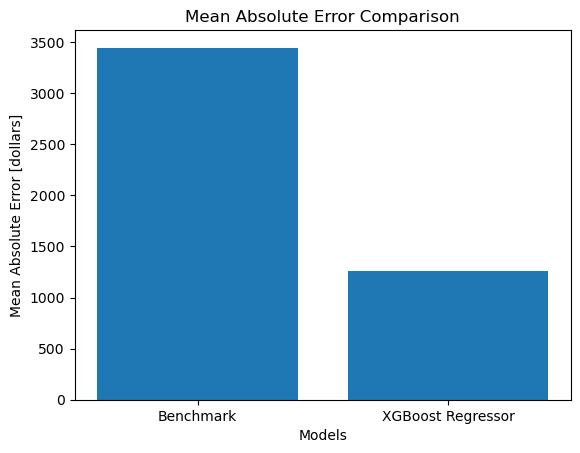

In [9]:
# Plot the two Mean Absolute Error
mae_values = [mae_baseline, maeXGBmodel]
labels = ["Benchmark", "XGBoost Regressor"]
plt.bar(labels, mae_values)
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error [dollars]")
plt.title("Mean Absolute Error Comparison");

In [10]:
# Get feature names for one-hot encoded columns
onehot_feature_names = preprocessor.named_transformers_["onehot"].get_feature_names_out(catColumns)

# Get remaining (non-categorical) feature names
nonCat_features = [f for f in X.columns if f not in catColumns]

# Combine all feature names into a single list
feature_names = list(onehot_feature_names) + nonCat_features

# Get features' importance values
importances = XGBmodel.feature_importances_.round(2)

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
importance_df.set_index("Feature", inplace=True)

# Print the top 7 feature importance
importance_df.head(7)

,Importance
Feature,
Fuel_Type_Diesel,0.44
Selling_type_Individual,0.17
Transmission_Manual,0.17
Brand_Toyota,0.14
Brand_Hyundai,0.02
Brand_Maruti,0.02
Driven_kms,0.02


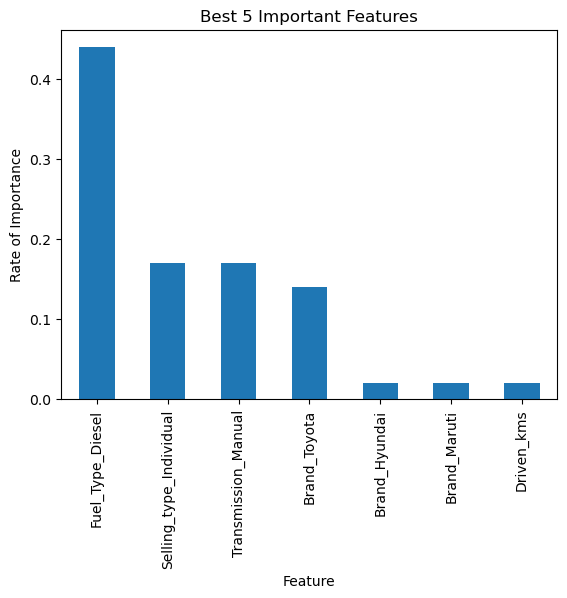

In [11]:
# Plot the top 7 feature importance
importance_df.head(7).plot(kind = "bar",
                           ylabel = "Rate of Importance",
                           title = "Best 5 Important Features",
                           legend = False);

In [12]:
# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout for the app
app.layout = dbc.Container(
    [
        html.H1("Car Price Prediction", style={"textAlign": "center"}),
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Driven KMs"),
                    dcc.Input(id="driven_kms", type="number", value=int(X["Driven_kms"].mean()), min=int(X["Driven_kms"].min()), max=int(X["Driven_kms"].max())),
                ]),
                dbc.Col([
                    html.Label("Fuel Type"),
                    dcc.Dropdown(
                        id="fuel_type",
                        options=[{"label": ft, "value": ft} for ft in sorted(X["Fuel_Type"].unique())],
                        value=sorted(X["Fuel_Type"].unique())[0],
                    ),
                ]),
            ]
        ),
        dbc.Row(
            [
                dbc.Col([
                    html.Label("Selling Type"),
                    dcc.Dropdown(
                        id="selling_type",
                        options=[{"label": st, "value": st} for st in sorted(X["Selling_type"].unique())],
                        value=sorted(X["Selling_type"].unique())[0],
                    ),
                ]),
                dbc.Col([
                    html.Label("Transmission"),
                    dcc.Dropdown(
                        id="transmission",
                        options=[{"label": tr, "value": tr} for tr in sorted(X["Transmission"].unique())],
                        value=sorted(X["Transmission"].unique())[0],
                    ),
                ]),
                dbc.Col([
                    html.Label("Brand"),
                    dcc.Dropdown(
                        id="brand",
                        options=[{"label": br, "value": br} for br in sorted(X["Brand"].unique())],
                        value=sorted(X["Brand"].unique())[0],
                    ),
                ]),
            ]
        ),
        dbc.Button("Predict Price", id="predict_button", color="primary", style={"marginTop": "20px"}),
        html.Div(id="output_div", style={"marginTop": "20px", "fontSize": "20px", "textAlign": "center"}),
    ],
    fluid=True,
)

In [13]:
# Callback to handle predictions
@app.callback(
    Output("output_div", "children"),
    Input("predict_button", "n_clicks"),
    State("driven_kms", "value"),
    State("fuel_type", "value"),
    State("selling_type", "value"),
    State("transmission", "value"),
    State("brand", "value"),
)

# Prediction function for users
def predict_price(n_clicks, driven_kms, fuel_type, selling_type, transmission, brand):
    if n_clicks is None:
        return "Enter inputs and click 'Predict Price'"
    
    # Create a DataFrame with the user's input
    input_data = {
        "Driven_kms": [driven_kms],
        "Fuel_Type": [fuel_type],
        "Selling_type": [selling_type],
        "Transmission": [transmission],
        "Brand": [brand]
    }
    df = pd.DataFrame(input_data)

    # Transform the user input to the same preprocessing steps used in training
    try:
        df_transformed = preprocessor.transform(df)
    except Exception as e:
        return f"Error in preprocessing: {e}"

    # Predict price using the trained model
    try:
        price_prediction = round(XGBmodel.predict(df_transformed)[0], 2)
    except Exception as e:
        return f"Error in prediction: {e}"

    # Return the predicted price
    return f"Predicted Price: {price_prediction:.2f} Dollars"

In [14]:
# Run the app
if __name__ == "__main__":
    app.run_server(debug=True)